### 711 Stores - Macro Space Category Analysis

### 1. Calculate number of sales days

In [53]:
# import libraries
import pandas as pd
import numpy as np
firstday='2021-12-13'
lastday='2022-06-20'

# calculate number of opened days by store
df=pd.read_csv('transactions_day_store_cat1.csv')
df['sales_date']=pd.to_datetime(df['sales_date'], infer_datetime_format=True) 
Ndays=df[(df['sales_date']>=firstday)&(df['sales_date']<=lastday)].groupby(['store_id','sales_date'])['total_sales'].sum().reset_index().groupby(['store_id'])['sales_date'].count().rename('Ndays').reset_index()
Ndays['store_id'] = Ndays['store_id'].astype(str)
Ndays


,store_id,Ndays
0,2,151
1,3,160
2,4,76
3,5,153
4,7,157
...,...,...
3135,9988,72
3136,9991,119
3137,9992,155
3138,9994,119


### 2. Calculate sales by store by category , divided by (1)

In [54]:
#sales by store by category
df_sales=df[(df['sales_date']>=firstday)&(df['sales_date']<=lastday)].groupby(['store_id','cat1_id','cat1_name'])['total_sales'].sum().reset_index()
df_sales=df_sales[(df_sales['total_sales']>0)]
df_sales['store_id'] = df_sales['store_id'].astype(str)
df_sales['cat1_id'] = df_sales['cat1_id'].astype(str)

#sales by store by category by day
df_sales=df_sales.merge(Ndays,left_on=['store_id'],right_on=['store_id'])
df_sales['daily_sales']=df_sales['total_sales']/df_sales['Ndays']
df_sales

,store_id,cat1_id,cat1_name,total_sales,Ndays,daily_sales
0,2,10,Grocery,213717.15,151,1415.345364
1,2,11,ICT Cards / Services,41140791.13,151,272455.570397
2,2,12,Noodles,129734.00,151,859.165563
3,2,18,Non-Foods,279784.00,151,1852.874172
4,2,21,Bottled Water/Energy Drinks,666888.00,151,4416.476821
...,...,...,...,...,...,...
95758,9992,36,Crunch Time,200379.00,155,1292.767742
95759,9994,31,Softdrinks,2065.00,119,17.352941
95760,9994,36,Crunch Time,173733.00,119,1459.941176
95761,9999,31,Softdrinks,2656.00,110,24.145455


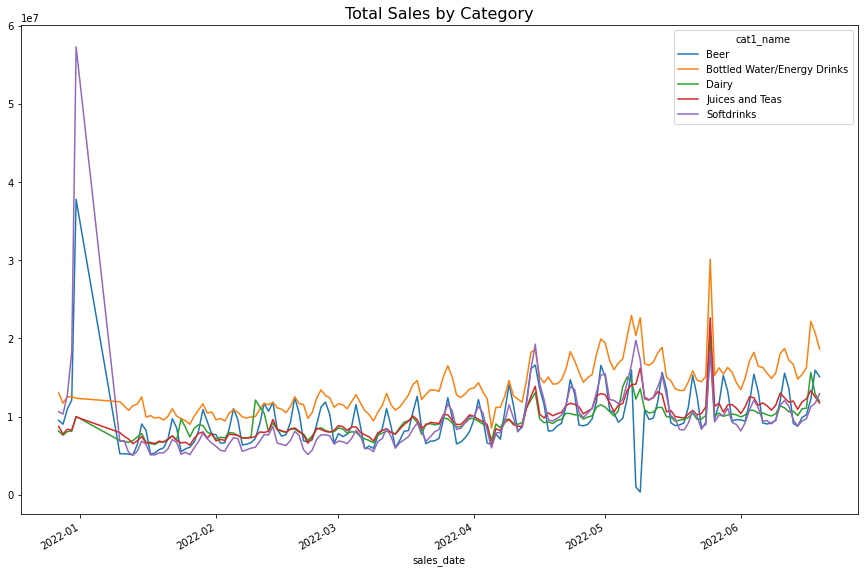

In [137]:
#plot total sales for beverages categories
import matplotlib.pyplot as plt

df[(df['sales_date']>=firstday)&(df['sales_date']<=lastday)
   &(df['cat1_id'].isin(['21','24','27','31','32']))]\
    .groupby(['sales_date','cat1_name'])['total_sales'].sum()\
    .unstack().plot(kind='line',figsize=(15, 10))

plt.title('Total Sales by Category',fontsize=16)
plt.show()

### 3. Fixtures Information

In [55]:
# calculate total widht by category by store

#Planograms version information
df_pogs=pd.read_csv('PSC_Latest_VAULT_POG (1).csv')
df_pogs=df_pogs.groupby(['store_code','category_code','version_code']).size().reset_index()
df_pogs['store_code'] = df_pogs['store_code'].astype(str)
df_pogs['category_code'] = df_pogs['category_code'].astype(str)

#Retrieve information about total width on shelfs by category
df_spaces=pd.read_excel('PSC_informationv2.xlsx',sheet_name='Space')
df_spaces['width_shelfs']=df_spaces['Maximum Layer']*df_spaces['Width']
df_spaces=df_spaces.groupby(['Catcode','GT CODE.1']).agg({'width_shelfs': 'sum', 'Width': 'mean', 'Sections':'sum'}).reset_index().rename(columns={'width_shelfs':'total_width','Width':'shelf_width'})
df_spaces=df_spaces.rename(columns={'Catcode':'cat1_id','GT CODE.1':'version_code'})
df_spaces['cat1_id'] = df_spaces['cat1_id'].astype(str)

#Merge planogram category information with shelfs width information by category by store
df_jobs=df_pogs.merge(df_spaces,how='left',left_on=['category_code','version_code'],right_on=['cat1_id','version_code'])
df_jobs=df_jobs[(~(df_jobs['total_width'].isna()))&(df_jobs['total_width']!=0)]
df_jobs=df_jobs.merge(df_jobs.groupby(['store_code','category_code'])['total_width'].max().reset_index(),on=['store_code','category_code','total_width'])[['store_code','category_code','version_code','total_width','Sections']]
df_jobs=df_jobs.merge(df_jobs.groupby(['store_code'])['total_width'].sum()
                      .reset_index()
                      .rename(columns={'total_width':'width5'})
                      ,left_on='store_code',right_on='store_code')
df_jobs

,store_code,category_code,version_code,total_width,Sections,width5
0,2,21,1HD,612.0,1.5,3152.0
1,2,24,1HD,660.0,1.5,3152.0
2,2,27,2DOW,1016.0,2.0,3152.0
3,2,31,1D,402.0,1.0,3152.0
4,2,32,1D,462.0,1.0,3152.0
...,...,...,...,...,...,...
10002,9999,21,2D,779.0,2.0,3507.0
10003,9999,24,2D,806.0,2.0,3507.0
10004,9999,27,2D,924.0,2.0,3507.0
10005,9999,31,1HD,536.0,1.5,3507.0


### 4. Calculate Daily Sales by Total Widht. Divide (2) by (3)

In [56]:
#Calculate total daily_sales by total width
df_sales=df_sales.merge(df_jobs,left_on=['store_id','cat1_id'],right_on=['store_code','category_code'])
df_sales['DailySales/Space']=df_sales['daily_sales']/df_sales['total_width']
df_sales=df_sales[(~(df_sales['DailySales/Space'].isna()))&(df_sales['total_width']!=0)][['store_id','cat1_id','cat1_name','total_sales','Ndays','daily_sales','total_width', 'width5', 'DailySales/Space']]
df_sales['total_width']=df_sales['total_width'].apply(np.floor).astype(int)

df_sales

,store_id,cat1_id,cat1_name,total_sales,Ndays,daily_sales,total_width,width5,DailySales/Space
0,2,21,Bottled Water/Energy Drinks,666888.0,151,4416.476821,612,3152.0,7.216465
1,2,24,Juices and Teas,374388.0,151,2479.390728,660,3152.0,3.756653
2,2,27,Dairy,389297.0,151,2578.125828,1016,3152.0,2.537525
3,2,31,Softdrinks,614437.0,151,4069.119205,402,3152.0,10.122187
4,2,32,Beer,1033855.0,151,6846.721854,462,3152.0,14.819744
...,...,...,...,...,...,...,...,...,...
9233,9988,31,Softdrinks,795.0,72,11.041667,536,3507.0,0.020600
9234,9991,31,Softdrinks,1123.0,119,9.436975,536,3507.0,0.017606
9235,9992,31,Softdrinks,1389.0,155,8.961290,536,3507.0,0.016719
9236,9994,31,Softdrinks,2065.0,119,17.352941,536,3507.0,0.032375


### 5. Normalization

In [57]:
#Calculate Total Sales by Store by Category
df_sales=df_sales.merge(df_sales.groupby(['cat1_id'])['total_sales'].sum().rename('TS_byCat1'),left_on=['cat1_id'],right_index=True)
df_sales=df_sales.merge(df_sales.groupby(['store_id'])['total_sales'].sum().rename('TS_byStor'),left_on=['store_id'],right_index=True)

#remove store with just one category
df_sales['TS_Norm']=df_sales['total_sales']/df_sales['TS_byStor']
df_sales=df_sales[~(df_sales['TS_Norm']==1)]

df_sales

,store_id,cat1_id,cat1_name,total_sales,Ndays,daily_sales,total_width,width5,DailySales/Space,TS_byCat1,TS_byStor,TS_Norm
0,2,21,Bottled Water/Energy Drinks,666888.0,151,4416.476821,612,3152.0,7.216465,1.427183e+09,3078865.0,0.216602
1,2,24,Juices and Teas,374388.0,151,2479.390728,660,3152.0,3.756653,9.478999e+08,3078865.0,0.121599
2,2,27,Dairy,389297.0,151,2578.125828,1016,3152.0,2.537525,9.052484e+08,3078865.0,0.126442
3,2,31,Softdrinks,614437.0,151,4069.119205,402,3152.0,10.122187,9.569768e+08,3078865.0,0.199566
4,2,32,Beer,1033855.0,151,6846.721854,462,3152.0,14.819744,9.023452e+08,3078865.0,0.335791
...,...,...,...,...,...,...,...,...,...,...,...,...
8654,3764,27,Dairy,408282.0,166,2459.530120,399,1026.0,6.164236,9.052484e+08,1018939.0,0.400693
8655,3764,31,Softdrinks,346685.0,166,2088.463855,342,1026.0,6.106619,9.569768e+08,1018939.0,0.340241
8656,3764,32,Beer,263972.0,166,1590.192771,285,1026.0,5.579624,9.023452e+08,1018939.0,0.259066
8619,3744,31,Softdrinks,162991.0,144,1131.881944,342,627.0,3.309596,9.569768e+08,258782.0,0.629839


In [58]:
#number of transactions by store by category
df_nbtr_cat=pd.read_csv('stores_nt_cat.csv')
df_nbtr_cat['store_id'] = df_nbtr_cat['store_id'].astype(str)
df_nbtr_cat['cat1_id'] = df_nbtr_cat['cat1_id'].astype(str)
df_nbtr_cat=df_nbtr_cat.groupby(['store_id','cat1_id'])['count'].mean().reset_index().rename(columns={'count':'nbtr_cat'})

df_nbtr_cat=df_nbtr_cat.merge(df_nbtr_cat.groupby(['store_id'])['nbtr_cat'].sum()
                              .reset_index()
                              .rename(columns={'nbtr_cat':'nbtr5'})
                              ,left_on='store_id',right_on='store_id')

#number of transactions by store
df_nbtr=pd.read_csv('stores_nt.csv')
df_nbtr['store_id'] = df_nbtr['store_id'].astype(str)
df_nbtr=df_nbtr.groupby(['store_id'])['count'].mean().reset_index().rename(columns={'count':'nbtr'})

#merge sales table with information of number of transactions
df_sales=df_sales.merge(df_nbtr, left_on=['store_id'],right_on=['store_id'])
df_sales=df_sales.merge(df_nbtr_cat, left_on=['store_id','cat1_id'],right_on=['store_id','cat1_id'])
df_sales

,store_id,cat1_id,cat1_name,total_sales,Ndays,daily_sales,total_width,width5,DailySales/Space,TS_byCat1,TS_byStor,TS_Norm,nbtr,nbtr_cat,nbtr5
0,2,21,Bottled Water/Energy Drinks,666888.0,151,4416.476821,612,3152.0,7.216465,1.427183e+09,3078865.0,0.216602,208.447368,81.013158,236.181684
1,2,24,Juices and Teas,374388.0,151,2479.390728,660,3152.0,3.756653,9.478999e+08,3078865.0,0.121599,208.447368,43.682119,236.181684
2,2,27,Dairy,389297.0,151,2578.125828,1016,3152.0,2.537525,9.052484e+08,3078865.0,0.126442,208.447368,39.605263,236.181684
3,2,31,Softdrinks,614437.0,151,4069.119205,402,3152.0,10.122187,9.569768e+08,3078865.0,0.199566,208.447368,46.947368,236.181684
4,2,32,Beer,1033855.0,151,6846.721854,462,3152.0,14.819744,9.023452e+08,3078865.0,0.335791,208.447368,24.933775,236.181684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9196,3764,27,Dairy,408282.0,166,2459.530120,399,1026.0,6.164236,9.052484e+08,1018939.0,0.400693,148.131737,47.964072,166.738800
9197,3764,31,Softdrinks,346685.0,166,2088.463855,342,1026.0,6.106619,9.569768e+08,1018939.0,0.340241,148.131737,28.281437,166.738800
9198,3764,32,Beer,263972.0,166,1590.192771,285,1026.0,5.579624,9.023452e+08,1018939.0,0.259066,148.131737,8.379518,166.738800
9199,3744,31,Softdrinks,162991.0,144,1131.881944,342,627.0,3.309596,9.569768e+08,258782.0,0.629839,185.324138,23.820690,201.683554


In [59]:
#Daily Sales Normalized = Daily Sales/ Number of transactions
df_sales['DS_Norm']=df_sales['daily_sales']/(df_sales['nbtr5'])
#Calcualate Daily Sales Normalized / Total Width
df_sales['DS_Norm/Space']=df_sales['DS_Norm']/df_sales['total_width']
df_sales

,store_id,cat1_id,cat1_name,total_sales,Ndays,daily_sales,total_width,width5,DailySales/Space,TS_byCat1,TS_byStor,TS_Norm,nbtr,nbtr_cat,nbtr5,DS_Norm,DS_Norm/Space
0,2,21,Bottled Water/Energy Drinks,666888.0,151,4416.476821,612,3152.0,7.216465,1.427183e+09,3078865.0,0.216602,208.447368,81.013158,236.181684,18.699489,0.030555
1,2,24,Juices and Teas,374388.0,151,2479.390728,660,3152.0,3.756653,9.478999e+08,3078865.0,0.121599,208.447368,43.682119,236.181684,10.497811,0.015906
2,2,27,Dairy,389297.0,151,2578.125828,1016,3152.0,2.537525,9.052484e+08,3078865.0,0.126442,208.447368,39.605263,236.181684,10.915858,0.010744
3,2,31,Softdrinks,614437.0,151,4069.119205,402,3152.0,10.122187,9.569768e+08,3078865.0,0.199566,208.447368,46.947368,236.181684,17.228767,0.042858
4,2,32,Beer,1033855.0,151,6846.721854,462,3152.0,14.819744,9.023452e+08,3078865.0,0.335791,208.447368,24.933775,236.181684,28.989216,0.062747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9196,3764,27,Dairy,408282.0,166,2459.530120,399,1026.0,6.164236,9.052484e+08,1018939.0,0.400693,148.131737,47.964072,166.738800,14.750797,0.036969
9197,3764,31,Softdrinks,346685.0,166,2088.463855,342,1026.0,6.106619,9.569768e+08,1018939.0,0.340241,148.131737,28.281437,166.738800,12.525362,0.036624
9198,3764,32,Beer,263972.0,166,1590.192771,285,1026.0,5.579624,9.023452e+08,1018939.0,0.259066,148.131737,8.379518,166.738800,9.537029,0.033463
9199,3744,31,Softdrinks,162991.0,144,1131.881944,342,627.0,3.309596,9.569768e+08,258782.0,0.629839,185.324138,23.820690,201.683554,5.612168,0.016410


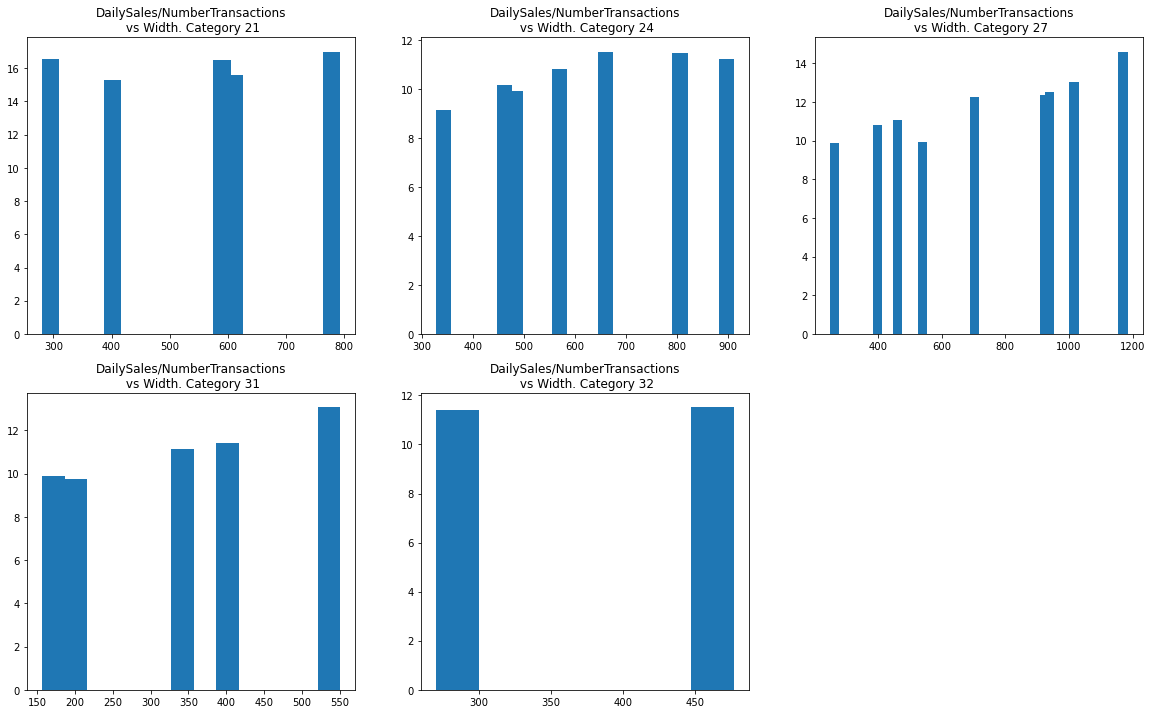

In [60]:
#Plot Curve
from matplotlib import pyplot as plt

#variable to plot
var_test='DS_Norm'
#calculate average Daily Sales Normalized
df_test=df_sales[['cat1_id','total_width',var_test]].groupby(['cat1_id','total_width'])[var_test].mean().reset_index()

#Analyzed Categories
Beverages_id=['21','24','27','31','32']

# Figure Size
plt.figure(figsize=(20, 12))

for idx,category_id in enumerate(Beverages_id):
    #Select category data
    space = df_test[(df_test['cat1_id']==category_id)]['total_width']
    DS_Norm = df_test[(df_test['cat1_id']==category_id)][var_test]
    # Horizontal Bar Plot
    plt.subplot(2, 3, idx+1)
    plt.bar(space,DS_Norm,width=30)
    #title
    plt.title('DailySales/NumberTransactions\n vs Width. Category %s' %category_id)

# Show Plot    
plt.show()

### 6. Modeling Negative Exponential Curve

In [61]:
# Create exponential parameters DataFrame
#Beverage Categories
data={'cat1_id':['21','24','27','31','32'],'cat1_name':['Bottled Water/Energy Drinks','Juices and Teas','Dairy','Softdrinks','Beer']}
df_param=pd.DataFrame(data)
df_param['a']=1.0
df_param['b']=1.0
df_param['c']=1.0
df_param.set_index('cat1_id',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


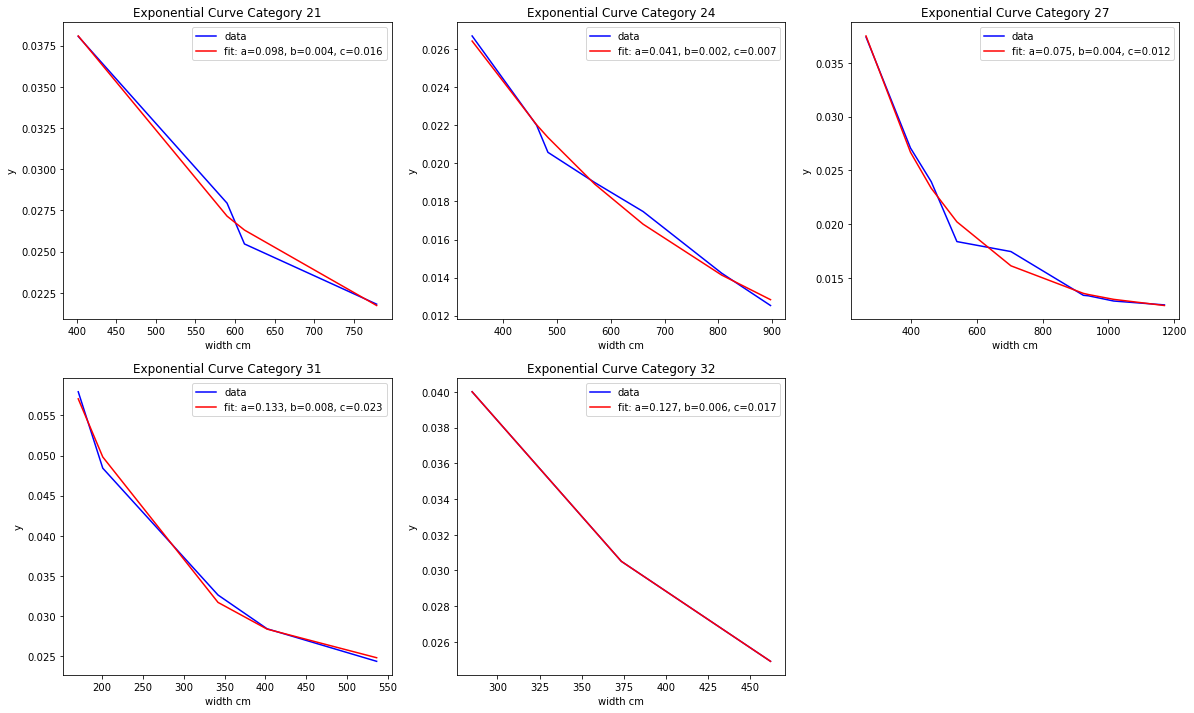

In [104]:
#Fit Curve
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

#Select variable to mathematically model
var_model='DS_Norm/Space'
#Calculate average Daily Sales Normalized
df_test=df_sales[['cat1_id','total_width',var_model]].groupby(['cat1_id','total_width'])[var_model].mean().reset_index()

#Define exponential function
def fexp(x, a, b, c):
    return a * np.exp(-b * x) + c

#Ommit data from total_width=295 in category 21, because this data correspond to an special type 
df_test=df_test[~((df_test['total_width']==295)&(df_test['cat1_id']=='21'))]

# Figure Size
plt.figure(figsize=(20, 12))

for idx,category_id in enumerate(Beverages_id):
    
    #select category data
    if category_id=='32':
        #create a 3th point
        space = df_test[(df_test['cat1_id']==category_id)]['total_width'].copy()
        space.loc[28]=space[27]
        space.loc[27]=(space[26]+space[28])/2

        ratio = df_test[(df_test['cat1_id']==category_id)][var_model].copy()
        ratio.loc[28]=ratio[27]
        ratio.loc[27]=(ratio[26]+ratio[28])*0.94/2

    else:
        space = df_test[(df_test['cat1_id']==category_id)]['total_width']
        ratio = df_test[(df_test['cat1_id']==category_id)][var_model]
    
    #Curve Fit: Calculate exponential curve parameters
    popt, pcov = curve_fit(fexp, space, ratio,p0=[1,.005,1])
    
    # Plot Curves
    plt.subplot(2, 3, idx+1)
    plt.plot(space,ratio, 'b-', label='data')
    plt.plot(space, fexp(space, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

    plt.xlabel('width cm')
    plt.ylabel('y')
    plt.legend()
    plt.title('Exponential Curve Category %s' %category_id)
    
    #store exponential curve parameters
    df_param.loc[category_id,'a']=popt[0]
    df_param.loc[category_id,'b']=popt[1]
    df_param.loc[category_id,'c']=popt[2]

#show plot
plt.show()

In [105]:
#Final Parameters of Negative Exponential Model
df_param

,cat1_name,a,b,c
cat1_id,,,,
21,Bottled Water/Energy Drinks,0.097588,0.003748,0.016464
24,Juices and Teas,0.040521,0.002104,0.006701
27,Dairy,0.074734,0.004037,0.011765
31,Softdrinks,0.132863,0.007950,0.022946
32,Beer,0.126757,0.005967,0.016863


### Forecast

In [107]:
#select beverage categories
df_stores=df_jobs[['store_code','category_code','total_width','Sections','version_code']]
df_stores=df_stores.rename(columns={'total_width':'width'})
df_stores=df_stores.pivot(index='store_code', columns='category_code')
df_stores=df_stores.swaplevel(1, 0, axis=1)
df_stores


category_code,21,24,27,31,32,21,24,27,31,32,21,24,27,31,32
,width,width,width,width,width,Sections,Sections,Sections,Sections,Sections,version_code,version_code,version_code,version_code,version_code
store_code,,,,,,,,,,,,,,,
10,612.0,660.0,1016.0,402.0,462.0,1.5,1.5,2.0,1.0,1.0,1HD,1HD,2DOW,1D,1D
100,779.0,660.0,462.0,402.0,462.0,2.0,1.5,1.0,1.0,1.0,2D,1HD,1D,1D,1D
1002,779.0,462.0,462.0,402.0,462.0,2.0,1.0,1.0,1.0,1.0,2D,1D,1D,1D,1D
1003,779.0,462.0,704.0,402.0,462.0,2.0,1.0,1.5,1.0,1.0,2D,1D,1HD,1D,1D
1005,779.0,660.0,264.0,402.0,462.0,2.0,1.5,0.5,1.0,1.0,2D,1HD,HD,1D,1D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,779.0,806.0,924.0,536.0,462.0,2.0,2.0,2.0,1.5,1.0,2D,2D,2D,1HD,1D
9991,779.0,806.0,924.0,536.0,462.0,2.0,2.0,2.0,1.5,1.0,2D,2D,2D,1HD,1D


In [129]:
#calculate re-normalization factor

#retrieve normalizatiom factor : number of transactions
df_NF=df_sales.groupby(['store_id','nbtr']).size().reset_index()[['store_id','nbtr']].set_index('store_id')
df_NF.columns = pd.MultiIndex.from_tuples([('NF','NF')])
df_stores=pd.concat([df_stores,df_NF],axis=1)

#retrieve information of initial daily sales
df_dss=df_sales[(df_sales['cat1_id'].isin( df_stores.columns.get_level_values('category_code')))]\
            .groupby(['store_id','cat1_id','DailySales/Space']).size().reset_index()\
            .rename(columns={'DailySales/Space':'DSS'})
df_dss=df_dss.pivot(index='store_id', columns='cat1_id', values='DSS')
df_dss.columns = pd.MultiIndex.from_product([df_dss.columns, ['DSS']])
df_stores=pd.concat([df_stores,df_dss],axis=1)

#with pd.option_context('display.max_columns', None,):
#    print(df_stores)
df_stores

category_code,21,24,27,31,32,21,24,27,31,32,...,24,27,31,32,NF,21,24,27,31,32
,width,width,width,width,width,Sections,Sections,Sections,Sections,Sections,...,DSS,DSS,DSS,DSS,NF,DSS,DSS,DSS,DSS,DSS
10,612.0,660.0,1016.0,402.0,462.0,1.5,1.5,2.0,1.0,1.0,...,5.529123,4.240891,6.667418,6.799747,352.426667,8.961146,5.529123,4.240891,6.667418,6.799747
100,779.0,660.0,462.0,402.0,462.0,2.0,1.5,1.0,1.0,1.0,...,5.274151,9.708992,7.574927,6.566213,339.311377,6.684388,5.274151,9.708992,7.574927,6.566213
1002,779.0,462.0,462.0,402.0,462.0,2.0,1.0,1.0,1.0,1.0,...,5.789013,7.290747,9.698166,10.437894,257.934132,7.796055,5.789013,7.290747,9.698166,10.437894
1003,779.0,462.0,704.0,402.0,462.0,2.0,1.0,1.5,1.0,1.0,...,9.428858,5.648728,9.600387,9.161073,302.425150,7.958543,9.428858,5.648728,9.600387,9.161073
1005,779.0,660.0,264.0,402.0,462.0,2.0,1.5,0.5,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,779.0,806.0,924.0,536.0,462.0,2.0,2.0,2.0,1.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9991,779.0,806.0,924.0,536.0,462.0,2.0,2.0,2.0,1.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9992,779.0,806.0,924.0,536.0,462.0,2.0,2.0,2.0,1.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Optimization

In [113]:
#read section information
df_sections=pd.read_excel('PSC_informationv2.xlsx',sheet_name='s3')
df_sections['Catcode']=df_sections['Catcode'].astype(str)

In [114]:
#define function to get section width
def get_width(section, category, version):
    return df_sections[(df_sections['Catcode']==category)&(df_sections['GT CODE']==version)][section]

In [116]:
#Create Optimization dataframe
df_optimize=df_stores[(~df_stores[('NF','NF')].isna())][[('21','width'),('24','width'),('27','width'),('31','width'),('32','width'),
                                                         ('21','Sections'),('24','Sections'),('27','Sections'),('31','Sections'),('32','Sections'),
                                                         ('21','version_code'),('24','version_code'),('27','version_code'),('31','version_code'),('32','version_code')]]

#Remove incomplete values
df_optimize=df_optimize[~(df_optimize.isna().any(axis='columns'))]
df_optimize.fillna(0,inplace=True)

#Constrain possible sections for each macrospace category
Op_21=[0.5, 1, 1.5, 2, 2.5, 3]
Op_24=[0.5, 1, 1.5, 2, 2.5, 3]
Op_27=[0.5, 1, 1.5, 2, 2.5, 3]
Op_31=[0.5, 1, 1.5, 2, 2.5, 3]
Op_32=[1, 2, 3]

for store_id_ in df_optimize.index:
    #read initial daily sales values
    sales_21i=df_stores.loc[store_id_,('21','DSS')]*df_stores.loc[store_id_,('21','width')]   
    sales_24i=df_stores.loc[store_id_,('24','DSS')]*df_stores.loc[store_id_,('24','width')]
    sales_27i=df_stores.loc[store_id_,('27','DSS')]*df_stores.loc[store_id_,('27','width')]
    sales_31i=df_stores.loc[store_id_,('31','DSS')]*df_stores.loc[store_id_,('31','width')]
    sales_32i=df_stores.loc[store_id_,('32','DSS')]*df_stores.loc[store_id_,('32','width')]
    sales_i=sales_21i+sales_24i+sales_27i+sales_31i+sales_32i
    
    #read initial sections values
    sct_21=df_optimize.loc[store_id_,('21','Sections')]
    sct_24=df_optimize.loc[store_id_,('24','Sections')]
    sct_27=df_optimize.loc[store_id_,('27','Sections')]
    sct_31=df_optimize.loc[store_id_,('31','Sections')]
    sct_32=df_optimize.loc[store_id_,('32','Sections')]
    section_total=sct_21+sct_24+sct_27+sct_31+sct_32

    #calculate possible combinations of categories sections
    comb=[[v,w,x,y,z] for v in [sct_21-0.5,sct_21,sct_21+0.5] for w in Op_24 for x in Op_27 for y in Op_31 for z in [sct_32,sct_32+1]  if (v+w+x+y+z)==section_total]
    df_comb = pd.DataFrame(comb, columns = ['sct_21f','sct_24f', 'sct_27f','sct_31f','sct_32f'])

    #calculate new value and find maximum
    
    #obtain "width" according to section, version and category
    df_comb['w_21f']=df_comb['sct_21f'].apply(get_width,category='21',version=df_optimize.loc[store_id_,('21','version_code')])
    df_comb['w_24f']=df_comb['sct_24f'].apply(get_width,category='24',version=df_optimize.loc[store_id_,('24','version_code')])
    df_comb['w_27f']=df_comb['sct_27f'].apply(get_width,category='27',version=df_optimize.loc[store_id_,('27','version_code')])
    df_comb['w_31f']=df_comb['sct_31f'].apply(get_width,category='31',version=df_optimize.loc[store_id_,('31','version_code')])
    df_comb['w_32f']=df_comb['sct_32f'].apply(get_width,category='32',version=df_optimize.loc[store_id_,('32','version_code')])

    #calculate initial math exponential values
    df_comb['exp_21i']=fexp(x=df_stores.loc[store_id_,('21','width')],a=df_param.loc['21','a'],b=df_param.loc['21','b'],c=df_param.loc['21','c'])
    df_comb['exp_24i']=fexp(x=df_stores.loc[store_id_,('24','width')],a=df_param.loc['24','a'],b=df_param.loc['24','b'],c=df_param.loc['24','c'])
    df_comb['exp_27i']=fexp(x=df_stores.loc[store_id_,('27','width')],a=df_param.loc['27','a'],b=df_param.loc['27','b'],c=df_param.loc['27','c'])
    df_comb['exp_31i']=fexp(x=df_stores.loc[store_id_,('31','width')],a=df_param.loc['31','a'],b=df_param.loc['31','b'],c=df_param.loc['31','c'])
    df_comb['exp_32i']=fexp(x=df_stores.loc[store_id_,('32','width')],a=df_param.loc['32','a'],b=df_param.loc['32','b'],c=df_param.loc['32','c'])

    #calculate initial math DSS, multiplying values from math model by Normalization factor
    df_comb['DSS_21i']=df_comb['exp_21i']*df_stores.loc[store_id_,('NF','NF')]
    df_comb['DSS_24i']=df_comb['exp_24i']*df_stores.loc[store_id_,('NF','NF')]
    df_comb['DSS_27i']=df_comb['exp_27i']*df_stores.loc[store_id_,('NF','NF')]
    df_comb['DSS_31i']=df_comb['exp_31i']*df_stores.loc[store_id_,('NF','NF')]
    df_comb['DSS_32i']=df_comb['exp_32i']*df_stores.loc[store_id_,('NF','NF')]

    #calculate initial math theoric sales, multiplying DSS from math model by width
    df_comb['sales_21i_math']=df_comb['DSS_21i']*df_stores.loc[store_id_,('21','width')]
    df_comb['sales_24i_math']=df_comb['DSS_24i']*df_stores.loc[store_id_,('24','width')]
    df_comb['sales_27i_math']=df_comb['DSS_27i']*df_stores.loc[store_id_,('27','width')]
    df_comb['sales_31i_math']=df_comb['DSS_31i']*df_stores.loc[store_id_,('31','width')]
    df_comb['sales_32i_math']=df_comb['DSS_32i']*df_stores.loc[store_id_,('32','width')]
    df_comb['tsalesi_math']=df_comb['sales_21i_math']+df_comb['sales_24i_math']+df_comb['sales_27i_math']+df_comb['sales_31i_math']+df_comb['sales_32i_math']
    
    #calculate exponential math model values
    df_comb['exp_21f']=df_comb['w_21f'].apply(fexp,a=df_param.loc['21','a'],b=df_param.loc['21','b'],c=df_param.loc['21','c'])
    df_comb['exp_24f']=df_comb['w_24f'].apply(fexp,a=df_param.loc['24','a'],b=df_param.loc['24','b'],c=df_param.loc['24','c'])
    df_comb['exp_27f']=df_comb['w_27f'].apply(fexp,a=df_param.loc['27','a'],b=df_param.loc['27','b'],c=df_param.loc['27','c'])
    df_comb['exp_31f']=df_comb['w_31f'].apply(fexp,a=df_param.loc['31','a'],b=df_param.loc['31','b'],c=df_param.loc['31','c'])
    df_comb['exp_32f']=df_comb['w_32f'].apply(fexp,a=df_param.loc['32','a'],b=df_param.loc['32','b'],c=df_param.loc['32','c'])

    #calculate math model DSS
    df_comb['DSS_21f']=df_comb['exp_21f']*df_stores.loc[store_id_,('NF','NF')]
    df_comb['DSS_24f']=df_comb['exp_24f']*df_stores.loc[store_id_,('NF','NF')]
    df_comb['DSS_27f']=df_comb['exp_27f']*df_stores.loc[store_id_,('NF','NF')]
    df_comb['DSS_31f']=df_comb['exp_31f']*df_stores.loc[store_id_,('NF','NF')]
    df_comb['DSS_32f']=df_comb['exp_32f']*df_stores.loc[store_id_,('NF','NF')]

    #calculate math model DSS
    df_comb['sales_21f']=df_comb['DSS_21f']*df_comb['w_21f']
    df_comb['sales_24f']=df_comb['DSS_24f']*df_comb['w_24f']
    df_comb['sales_27f']=df_comb['DSS_27f']*df_comb['w_27f']
    df_comb['sales_31f']=df_comb['DSS_31f']*df_comb['w_31f']
    df_comb['sales_32f']=df_comb['DSS_32f']*df_comb['w_32f']

    #calculate math model total sales
    df_comb['tsalesf']=df_comb['sales_21f']+df_comb['sales_24f']+df_comb['sales_27f']+df_comb['sales_31f']+df_comb['sales_32f']
    
    #calculate forecast deltas sales, based in porcentage increases of math model
    df_comb['delta_21']=((df_comb['sales_21f']/df_comb['sales_21i_math'])-1)*sales_21i
    df_comb['delta_24']=((df_comb['sales_24f']/df_comb['sales_24i_math'])-1)*sales_24i
    df_comb['delta_27']=((df_comb['sales_27f']/df_comb['sales_27i_math'])-1)*sales_27i
    df_comb['delta_31']=((df_comb['sales_31f']/df_comb['sales_31i_math'])-1)*sales_31i
    df_comb['delta_32']=((df_comb['sales_32f']/df_comb['sales_32i_math'])-1)*sales_32i
    df_comb['delta']=(df_comb['delta_21']+df_comb['delta_24']+df_comb['delta_27']+df_comb['delta_31']+df_comb['delta_32'])/(sales_i)

    #read initial sales values for each category
    df_optimize.loc[store_id_,'sales_21i']=sales_21i
    df_optimize.loc[store_id_,'sales_24i']=sales_24i
    df_optimize.loc[store_id_,'sales_27i']=sales_27i
    df_optimize.loc[store_id_,'sales_31i']=sales_31i
    df_optimize.loc[store_id_,'sales_32i']=sales_32i
    df_optimize.loc[store_id_,'tsalesi']=sales_i
    
    #categories delta values for the optimized forecast value
    df_optimize.loc[store_id_,'sales_21i_math']=df_comb.loc[df_comb['delta'].idxmax()]['sales_21i_math'].copy()
    df_optimize.loc[store_id_,'sales_24i_math']=df_comb.loc[df_comb['delta'].idxmax()]['sales_24i_math'].copy()
    df_optimize.loc[store_id_,'sales_27i_math']=df_comb.loc[df_comb['delta'].idxmax()]['sales_27i_math'].copy()
    df_optimize.loc[store_id_,'sales_31i_math']=df_comb.loc[df_comb['delta'].idxmax()]['sales_31i_math'].copy()
    df_optimize.loc[store_id_,'sales_32i_math']=df_comb.loc[df_comb['delta'].idxmax()]['sales_32i_math'].copy()
    
    df_optimize.loc[store_id_,'delta_21']=df_comb.loc[df_comb['delta'].idxmax()]['delta_21'].copy()
    df_optimize.loc[store_id_,'delta_24']=df_comb.loc[df_comb['delta'].idxmax()]['delta_24'].copy()
    df_optimize.loc[store_id_,'delta_27']=df_comb.loc[df_comb['delta'].idxmax()]['delta_27'].copy()
    df_optimize.loc[store_id_,'delta_31']=df_comb.loc[df_comb['delta'].idxmax()]['delta_31'].copy()
    df_optimize.loc[store_id_,'delta_32']=df_comb.loc[df_comb['delta'].idxmax()]['delta_32'].copy()
    
    #sections values for the optimized forecast value
    df_optimize.loc[store_id_,'sct_21f']=df_comb.loc[df_comb['delta'].idxmax()]['sct_21f'].copy()
    df_optimize.loc[store_id_,'sct_24f']=df_comb.loc[df_comb['delta'].idxmax()]['sct_24f'].copy()
    df_optimize.loc[store_id_,'sct_27f']=df_comb.loc[df_comb['delta'].idxmax()]['sct_27f'].copy()
    df_optimize.loc[store_id_,'sct_31f']=df_comb.loc[df_comb['delta'].idxmax()]['sct_31f'].copy()
    df_optimize.loc[store_id_,'sct_32f']=df_comb.loc[df_comb['delta'].idxmax()]['sct_32f'].copy()
    
    #sections values for the optimized forecast value
    df_optimize.loc[store_id_,'w_21f']=df_comb.loc[df_comb['delta'].idxmax()]['w_21f'].copy()
    df_optimize.loc[store_id_,'w_24f']=df_comb.loc[df_comb['delta'].idxmax()]['w_24f'].copy()
    df_optimize.loc[store_id_,'w_27f']=df_comb.loc[df_comb['delta'].idxmax()]['w_27f'].copy()
    df_optimize.loc[store_id_,'w_31f']=df_comb.loc[df_comb['delta'].idxmax()]['w_31f'].copy()
    df_optimize.loc[store_id_,'w_32f']=df_comb.loc[df_comb['delta'].idxmax()]['w_32f'].copy()
    
    #optimzed forecast sales
    df_optimize.loc[store_id_,'sales_21f']=sales_21i+df_comb.loc[df_comb['delta'].idxmax()]['delta_21'].copy()
    df_optimize.loc[store_id_,'sales_24f']=sales_24i+df_comb.loc[df_comb['delta'].idxmax()]['delta_24'].copy()
    df_optimize.loc[store_id_,'sales_27f']=sales_27i+df_comb.loc[df_comb['delta'].idxmax()]['delta_27'].copy()
    df_optimize.loc[store_id_,'sales_31f']=sales_31i+df_comb.loc[df_comb['delta'].idxmax()]['delta_31'].copy()
    df_optimize.loc[store_id_,'sales_32f']=sales_32i+df_comb.loc[df_comb['delta'].idxmax()]['delta_32'].copy()
    
    #optimized total forecast sales 
    df_optimize.loc[store_id_,'tsalesf']=(sales_21i+df_comb.loc[df_comb['delta'].idxmax()]['delta_21'].copy()
                                        +sales_24i+df_comb.loc[df_comb['delta'].idxmax()]['delta_24'].copy()
                                        +sales_27i+df_comb.loc[df_comb['delta'].idxmax()]['delta_27'].copy()
                                        +sales_31i+df_comb.loc[df_comb['delta'].idxmax()]['delta_31'].copy()
                                        +sales_32i+df_comb.loc[df_comb['delta'].idxmax()]['delta_32'].copy())
    
    #theoric math model total sales delta
    df_optimize.loc[store_id_,'delta_math']=df_comb.loc[df_comb['delta'].idxmax()]['delta'].copy()
    
    #real total delta sales
    df_optimize.loc[store_id_,'delta_real']=((df_comb.loc[df_comb['delta'].idxmax()]['delta_21'].copy()
                                            +df_comb.loc[df_comb['delta'].idxmax()]['delta_24'].copy()
                                            +df_comb.loc[df_comb['delta'].idxmax()]['delta_27'].copy()
                                            +df_comb.loc[df_comb['delta'].idxmax()]['delta_31'].copy()
                                            +df_comb.loc[df_comb['delta'].idxmax()]['delta_32'].copy())/
                                            (sales_i))

#write csv
df_optimize.to_csv('df_optimization_dss.csv')
df_optimize

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


category_code,21,24,27,31,32,21,24,27,31,32,...,w_31f,w_32f,sales_21f,sales_24f,sales_27f,sales_31f,sales_32f,tsalesf,delta_math,delta_real
,width,width,width,width,width,Sections,Sections,Sections,Sections,Sections,...,,,,,,,,,,
10,612.0,660.0,1016.0,402.0,462.0,1.5,1.5,2.0,1.0,1.0,...,1206.0,924.0,5226.944302,2601.423292,3255.081010,6502.978254,4381.652683,21968.079540,0.140371,0.140371
100,779.0,660.0,462.0,402.0,462.0,2.0,1.5,1.0,1.0,1.0,...,1206.0,462.0,4938.572474,2481.460176,4119.109672,7388.104839,3033.590361,21960.837522,0.140684,0.140684
1002,779.0,462.0,462.0,402.0,462.0,2.0,1.0,1.0,1.0,1.0,...,1005.0,462.0,5759.895782,2077.933786,3093.152074,7894.815396,4822.307229,23648.104267,0.134912,0.134912
1003,779.0,462.0,704.0,402.0,462.0,2.0,1.0,1.5,1.0,1.0,...,1206.0,462.0,5879.945626,3384.435748,3439.957485,9363.610614,4232.415663,26300.365136,0.162482,0.162482
1009,612.0,462.0,704.0,402.0,462.0,1.5,1.0,1.5,1.0,1.0,...,1206.0,462.0,3987.482349,1788.675341,2309.074359,6048.559117,1897.291925,16031.083092,0.183487,0.183487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,612.0,660.0,462.0,402.0,462.0,1.5,1.5,1.0,1.0,1.0,...,1206.0,462.0,4313.856009,3090.591063,3658.756424,12047.175380,4649.674699,27760.053574,0.235925,0.235925
995,612.0,462.0,1016.0,402.0,462.0,1.5,1.0,2.0,1.0,1.0,...,1005.0,924.0,2870.080219,1328.958218,1558.248367,4724.668448,4780.286785,15262.242036,0.216603,0.216603
996,612.0,660.0,264.0,201.0,462.0,1.5,1.5,0.5,0.5,1.0,...,938.0,462.0,5526.904182,2310.882227,2766.506024,5696.146187,3139.186747,19439.625367,0.105284,0.105284


### Validation

In [127]:

df_factors=df_optimize[[('21','width'),('24','width'),('27','width'),('31','width'),('32','width'),('w_21f',''),('w_24f',''),('w_27f',''),('w_31f',''),('w_32f','')]].copy()
df_factors.columns = df_factors.columns.to_flat_index()
df_factors['21']=df_factors[('w_21f','')]/df_factors[('21','width')]-1
df_factors['24']=df_factors[('w_24f','')]/df_factors[('24','width')]-1
df_factors['27']=df_factors[('w_27f','')]/df_factors[('27','width')]-1
df_factors['31']=df_factors[('w_31f','')]/df_factors[('31','width')]-1
df_factors['32']=df_factors[('w_32f','')]/df_factors[('32','width')]-1

#merge with factors
df_factors=df_factors.reset_index()[['index','21','24','27','31','32']].rename(columns={'index':'store_id'}).melt(id_vars=['store_id'], var_name='cat1_id', value_name='factor')

#import transactions. Read sales by items
df_sbi=pd.read_csv('sales_by_items.csv')
df_sbi['store_id'] = df_sbi['store_id'].astype(str)
df_sbi['item_id'] = df_sbi['item_id'].astype(str)

#add categories and stores
df_items=pd.read_csv('psc_items__20220630.csv')
df_sbi=df_sbi.merge(df_items[['id','cat1_id']],left_on="item_id",right_on='id')
df_sbi=df_sbi[(df_sbi['cat1_id']=='21')|(df_sbi['cat1_id']=='24')|(df_sbi['cat1_id']=='27')|(df_sbi['cat1_id']=='31')|(df_sbi['cat1_id']=='32')]
df_sbi=df_sbi[(df_sbi['store_id'].isin(df_optimize.index))]

#merge factor dataframe and sales dataframe and calculate sales  with new factor
df_sbi=df_sbi.merge(df_factors,left_on=['store_id','cat1_id'],right_on=['store_id','cat1_id'])
df_sbi['new_sales']=df_sbi['sales']*df_sbi['factor']

#aggregate new calculated sales
df_sbi=df_sbi.groupby(['store_id','cat1_id'])['new_sales'].sum().reset_index()
df_sbi=df_sbi.merge(Ndays,left_on='store_id',right_on='store_id')
df_sbi['new_dsales']=df_sbi['new_sales']/df_sbi['Ndays']
df_sbi=df_sbi.pivot(index='store_id', columns='cat1_id', values='new_dsales')
df_sbi

cat1_id,21,24,27,31,32
store_id,,,,,
10,-1844.544743,-2212.071141,-3181.751995,5405.395973,3166.261745
100,-1210.408618,-2103.683133,-1933.776248,6123.807229,0.000000
1002,-1411.896314,-1152.312392,-1451.124785,5869.156627,0.000000
1003,-1440.588799,-1882.071429,-2544.105148,7754.457831,0.000000
1009,-1405.652174,-992.680568,-1711.169960,5018.335404,0.000000
...,...,...,...,...,...
993,-1519.039157,-2617.525301,-1717.267642,9970.204819,0.000000
995,-1010.146586,-736.440620,-1519.073522,3512.891566,3446.674699
996,-1945.154618,-1956.957831,0.000000,9755.983936,0.000000


In [128]:
#validate optimization using new calculated sales
df_sbi=pd.concat([df_optimize,df_sbi],axis=1)
df_sbi['delta_val']=df_sbi['21']+df_sbi['24']+df_sbi['27']+df_sbi['31']+df_sbi['32']
df_sbi['delta_calculated']=(df_sbi[('tsalesf','')]-df_sbi[('tsalesi','')])
df_sbi['variation']=df_sbi['delta_val']/df_sbi['delta_calculated']
df_sbi.to_csv('df_validation.csv')
df_sbi

,"(21, width)","(24, width)","(27, width)","(31, width)","(32, width)","(21, Sections)","(24, Sections)","(27, Sections)","(31, Sections)","(32, Sections)",...,"(delta_math, )","(delta_real, )",21,24,27,31,32,delta_val,delta_calculated,variation
10,612.0,660.0,1016.0,402.0,462.0,1.5,1.5,2.0,1.0,1.0,...,0.140371,0.140371,-1844.544743,-2212.071141,-3181.751995,5405.395973,3166.261745,1333.289840,2704.106386,0.493061
100,779.0,660.0,462.0,402.0,462.0,2.0,1.5,1.0,1.0,1.0,...,0.140684,0.140684,-1210.408618,-2103.683133,-1933.776248,6123.807229,0.000000,875.939231,2708.494149,0.323405
1002,779.0,462.0,462.0,402.0,462.0,2.0,1.0,1.0,1.0,1.0,...,0.134912,0.134912,-1411.896314,-1152.312392,-1451.124785,5869.156627,0.000000,1853.823135,2811.158483,0.659452
1003,779.0,462.0,704.0,402.0,462.0,2.0,1.0,1.5,1.0,1.0,...,0.162482,0.162482,-1440.588799,-1882.071429,-2544.105148,7754.457831,0.000000,1887.692456,3676.051883,0.513511
1009,612.0,462.0,704.0,402.0,462.0,1.5,1.0,1.5,1.0,1.0,...,0.183487,0.183487,-1405.652174,-992.680568,-1711.169960,5018.335404,0.000000,908.832701,2485.449551,0.365661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,612.0,660.0,462.0,402.0,462.0,1.5,1.5,1.0,1.0,1.0,...,0.235925,0.235925,-1519.039157,-2617.525301,-1717.267642,9970.204819,0.000000,4116.372719,5299.098755,0.776806
995,612.0,462.0,1016.0,402.0,462.0,1.5,1.0,2.0,1.0,1.0,...,0.216603,0.216603,-1010.146586,-736.440620,-1519.073522,3512.891566,3446.674699,3693.905537,2717.278180,1.359414
996,612.0,660.0,264.0,201.0,462.0,1.5,1.5,0.5,0.5,1.0,...,0.105284,0.105284,-1945.154618,-1956.957831,0.000000,9755.983936,0.000000,5853.871486,1851.721753,3.161313
997,612.0,660.0,462.0,402.0,462.0,1.5,1.5,1.0,1.0,1.0,...,0.185688,0.185688,-955.465447,-1534.968293,-1195.374564,5065.439024,0.000000,1379.630720,2515.303672,0.548495
